In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abel import Transform
import imageio.v3 as iio
import abel

In [2]:
# Constants
PIXEL_SIZE_UM = 5  # Each pixel is 5 microns
PIXEL_SIZE_MM = PIXEL_SIZE_UM / 1000  # Convert to mm

# Load fluorescence image
image = iio.imread(r"H:\APL_files\bias_field\code_abel\image1_2025-03-24T16-47-50.758.tif")

# Get image size
height, width = image.shape
print(f"Image size: {width} × {height} pixels")

# Define axis limits for conversion to mm
x_extent_mm = width * PIXEL_SIZE_MM / 2
y_extent_mm = height * PIXEL_SIZE_MM / 2


Image size: 1920 × 1080 pixels


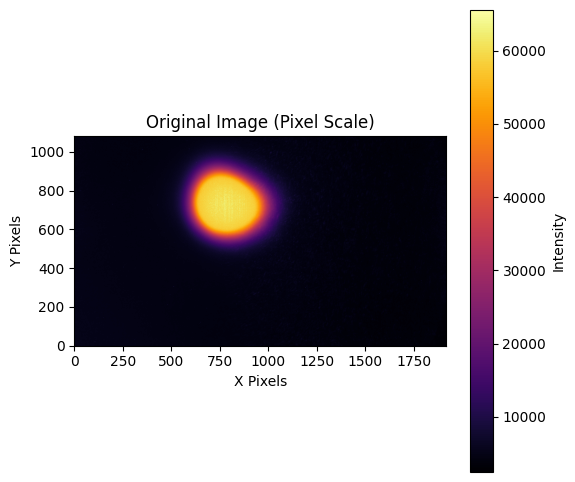

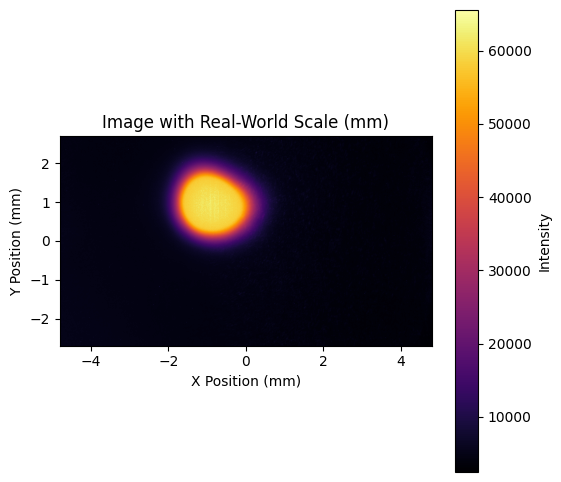

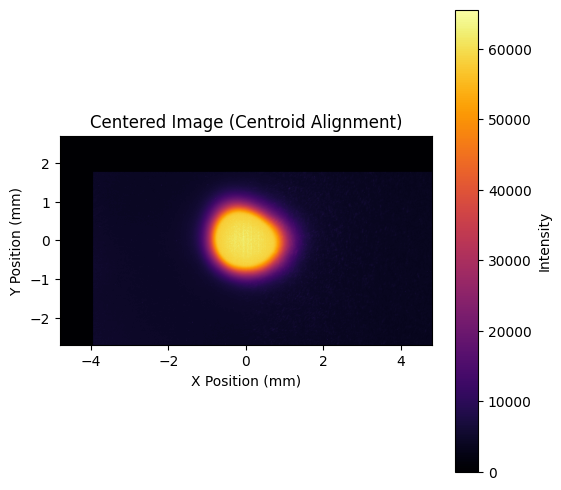

In [3]:
# Plot original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower")
plt.colorbar(label="Intensity")
plt.title("Original Image (Pixel Scale)")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.show()

# Plot image with real-world coordinates (mm)
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Image with Real-World Scale (mm)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

centered_image = abel.tools.center.center_image(image, method="gaussian")


# Plot centered image
plt.figure(figsize=(6, 6))
plt.imshow(centered_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered Image (Centroid Alignment)")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()


In [4]:
# Constants
DEMAG_FACTOR = 2.67
PIXEL_SIZE_UM = 5  # microns
PIXEL_SIZE_MM = (PIXEL_SIZE_UM * DEMAG_FACTOR) / 1000  # in mm
PIXEL_VOLUME_MM3 = PIXEL_SIZE_MM ** 3




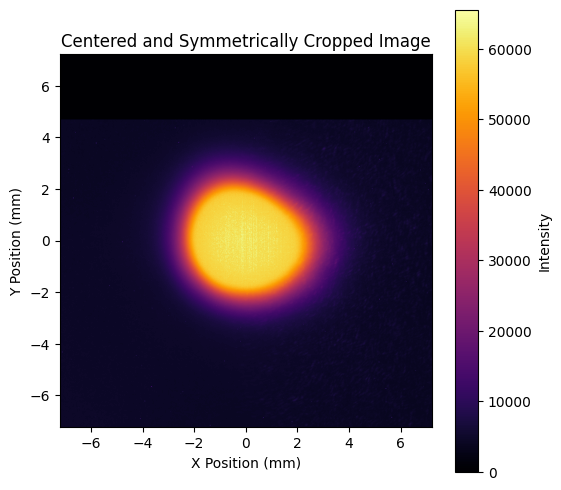

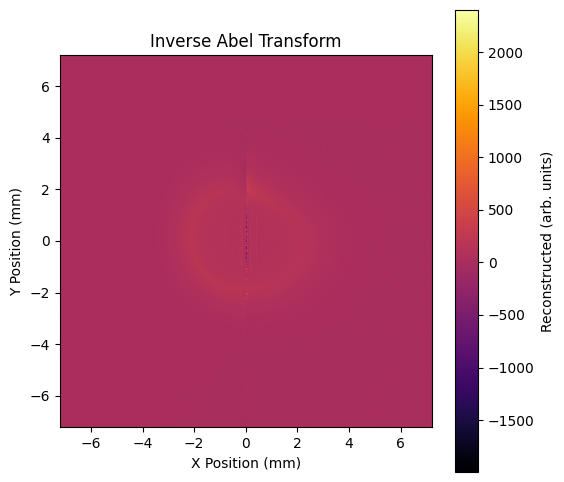

In [5]:
# ================================
# Step 1: Load reconstructed Abel data (already computed)
#         Assuming reconstructed and cropped_image are defined.
# Get image dimensions
height, width = centered_image.shape

# Find the center coordinates
center_x, center_y = width // 2, height // 2

# Define a symmetric crop size (smallest of half-width and half-height)
crop_size = min(center_x, center_y)

# Ensure cropping does not go out of bounds # Right side positions

x_start = center_x - crop_size
x_end = center_x + crop_size
y_start = center_y - crop_size
y_end = center_y + crop_size

# Perform symmetric cropping
cropped_image = centered_image[y_start:y_end, x_start:x_end]

# Define new extent for correct physical scaling
x_extent_mm = cropped_image.shape[1] * PIXEL_SIZE_MM / 2
y_extent_mm = cropped_image.shape[0] * PIXEL_SIZE_MM / 2

# Plot the cropped image
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Intensity")
plt.title("Centered and Symmetrically Cropped Image")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()


reconstructed = Transform(cropped_image, method='hansenlaw', direction='inverse').transform

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="inferno", origin="lower",
           extent=[-x_extent_mm, x_extent_mm, -y_extent_mm, y_extent_mm])
plt.colorbar(label="Reconstructed (arb. units)")
plt.title("Inverse Abel Transform")
plt.xlabel("X Position (mm)")
plt.ylabel("Y Position (mm)")
plt.show()

# ================================

# Define x positions relative to the cloud size
relative_x_positions = [0.0, 0.1,0.2,0.2] 
# Convert relative positions to pixel indices
x_indices = [int((r + 1) * cropped_image.shape[1] / 2) for r in relative_x_positions]

# Ensure indices are within bounds
x_indices = [max(0, min(idx, cropped_image.shape[1] - 1)) for idx in x_indices]

# Define y positions in mm
y_positions_mm = (np.arange(reconstructed.shape[0]) - reconstructed.shape[0] / 2) * PIXEL_SIZE_MM



In [6]:
# ===================================
# Step 2: Convert Abel transform to physical units (atoms/mm³)
# ===================================

# Total number of atoms (from calibration or estimate)
N_total_atoms = 1e8  # <-- Replace with your actual atom number

# Compute total signal in the reconstructed image
total_abel_signal = reconstructed.sum()

# Compute scale factor: atoms per unit of reconstructed signal
scale_factor = N_total_atoms / total_abel_signal

# Convert to atom density per pixel
density_atoms_per_pixel = reconstructed * scale_factor

# Convert to atoms/mm³
density_atoms_per_mm3 = density_atoms_per_pixel / PIXEL_VOLUME_MM3

# Choose one profile (e.g., at X = 0.54 mm, corresponding to x_indices[1])
abel_density_at_x = density_atoms_per_mm3[:, x_indices[3]]



In [7]:
# ===================================
# Step 3: Load and process experimental data
# ===================================

file_path ='H:\\APL_files\\bias_field\code_abel\\peak_to_peak_values.csv'
df = pd.read_csv(file_path)

# Experimental Y positions (in mm) and densities
y_exp = (df.iloc[:, 0].values)*61*0.005*2.67 +0.6 # Shift to center around x = 0.54 mm
exp_values = df.iloc[:, 1].values    # Experimental density values
exp_errors = df.iloc[:, 2].values    # Experimental errors (standard deviation)

# Optional: normalize experimental values if needed
# exp_values = (exp_values - np.min(exp_values)) / (np.max(exp_values) - np.min(exp_values))



<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\SAYARI\AppData\Local\Temp\ipykernel_12124\2751825741.py:5: SyntaxWarning: invalid escape sequence '\c'
  file_path ='H:\\APL_files\\bias_field\code_abel\\peak_to_peak_values.csv'


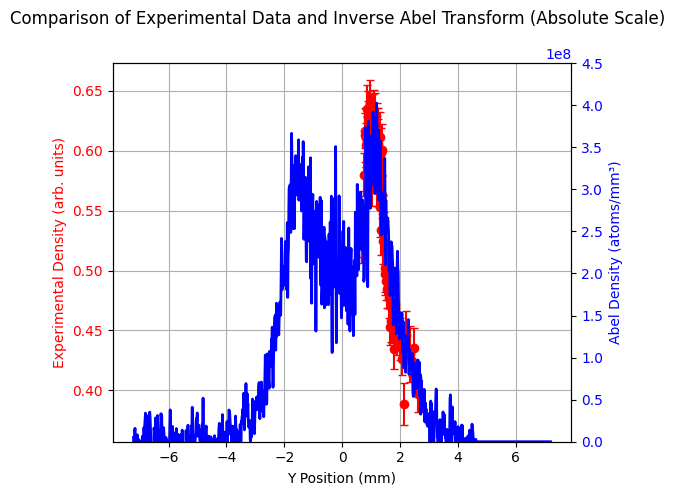

In [8]:
# ===================================
# Step 4: Plot comparison
# ===================================

fig, ax1 = plt.subplots(figsize=(6, 5))

# Plot experimental data
ax1.errorbar(y_exp, exp_values, yerr=exp_errors, fmt="o", capsize=3, label="Experimental Data", color="red")
ax1.set_xlabel("Y Position (mm)")
ax1.set_ylabel("Experimental Density (arb. units)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create second Y-axis for Abel density
ax2 = ax1.twinx()
ax2.plot(y_positions_mm, abel_density_at_x, label="Abel Transform (X=0.54 mm)", color="blue", linewidth=2)
ax2.set_ylabel("Abel Density (atoms/mm³)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
# ax2.set_xlim(0.5, 2.5)
ax2.set_ylim(0e8,4.5e8)
# Formatting
fig.suptitle("Comparison of Experimental Data and Inverse Abel Transform (Absolute Scale)")
ax1.grid(True)
fig.tight_layout()

# Show plot
plt.show()

# Save as NumPy binary (.npy)
np.save("abel_density_atoms_per_mm3.npy", density_atoms_per_mm3)

# Save as CSV (with x and y positions)
x_positions_mm = (np.arange(reconstructed.shape[1]) - reconstructed.shape[1] / 2) * PIXEL_SIZE_MM
df_abel = pd.DataFrame(data=density_atoms_per_mm3,
                       index=np.round(y_positions_mm, 6),
                       columns=np.round(x_positions_mm, 6))
df_abel.index.name = "Y (mm)"
df_abel.columns.name = "X (mm)"
df_abel.to_csv("abel_density_atoms_per_mm3.csv")
# Save only the 1D density profile at x_indices[1]
x_pos_mm = x_positions_mm[x_indices[1]]  # Get the corresponding X position in mm
density_profile = density_atoms_per_mm3[:, x_indices[3]]  # 1D profile along Y

# Create DataFrame for saving
df_profile = pd.DataFrame({
    "Y (mm)": y_positions_mm,
    f"Density at X = {x_pos_mm:.3f} mm (atoms/mm³)": density_profile
})

# # Save to CSV
df_profile.to_csv(f"final_abel_density_profile_x_{x_pos_mm:.3f}_mm.csv", index=False)

